In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt


In [3]:
from src.models import FCN, FCN_with_last_activation
from src.data_handler import DataHandler, RandomSamplingDataHandler
from src.constants import ALPHA
from src.experiment_run import Run

In [4]:
import astropy.units as u

In [5]:
torch.manual_seed(123)

In [6]:
data = np.load('data/test1.npy').T
data.shape

(2000, 10000)

In [7]:
params = pd.read_csv('data/params1.txt', sep=' ')
params = params.values
params.shape

(2000, 2)

In [8]:
dt = 50*u.yr
t_steps = 10000

scaling = 1e-6
# define the Universe time
u_time = np.arange(t_steps) * dt.value * scaling

In [9]:
dt.value

50.0

In [10]:
x = torch.tensor(u_time).float().view(-1,1)
y = torch.tensor(data[0]).float().view(-1,1)

In [11]:
nH, gamma = params[0].astype(float)

def physics_loss_fn(x, y, loss_coef=1.):
    # compute dy/dx
    dy = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    
    # compute the physic loss
    ode = dy * scaling- (1 - y) * gamma + ALPHA * nH * y ** 2

    return  torch.mean((loss_coef * ode) ** 2)

# Base

In [12]:
model = FCN([1, 8, 8, 8, 8, 8, 1], torch.nn.ELU)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=20,)

run = Run('modified_time/base')

run.data_handler = DataHandler(x, y, 2000, 20)
run.model = model
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = None

run.train(5000)

torch.Size([100, 1]) torch.Size([9900, 1])


100%|██████████| 5000/5000 [02:19<00:00, 35.93it/s]


In [13]:
run.score()

tensor(0.8890)

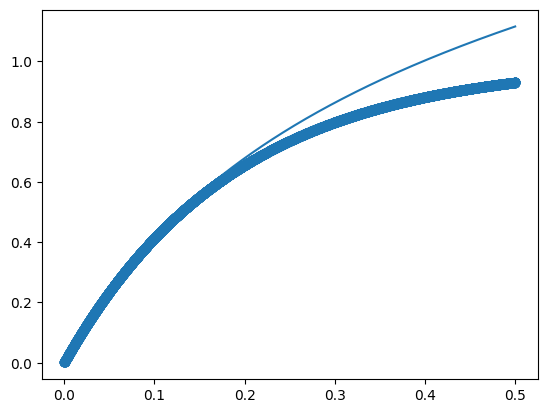

In [14]:
plt.plot(x, model(x).detach().numpy())
plt.scatter(x,y)

# Physics loss

In [15]:
model = FCN([1, 8, 8, 8, 8, 8, 1], torch.nn.ELU)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = Run('modified_time/base_physics_loss')

run.data_handler = DataHandler(x, y, 2000, 20)
run.model = model

run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = lambda x, y: physics_loss_fn(x, y, loss_coef=1000)

run.train(5000)

torch.Size([100, 1]) torch.Size([9900, 1])


100%|██████████| 5000/5000 [07:41<00:00, 10.84it/s]


In [16]:
run.score()

tensor(0.9852)

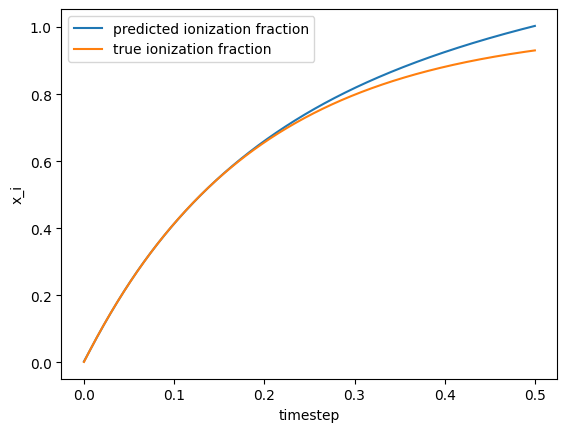

In [17]:
plt.plot(x, model(x).detach().numpy(), label="predicted ionization fraction")
plt.plot(x, y, label="true ionization fraction")
plt.xlabel("timestep")
plt.ylabel("x_i")
plt.legend()

# Two phases

In [18]:
model_1 = FCN([1, 8, 8, 8, 8, 8, 1], torch.nn.ELU)
optimizer = torch.optim.Adam(model_1.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=50,)

run = Run('modified_time/first_phase')

run.data_handler = DataHandler(x, y, 2000, 20)
run.model = model_1
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = None

run.train(3000)

torch.Size([100, 1]) torch.Size([9900, 1])


100%|██████████| 3000/3000 [01:33<00:00, 32.03it/s]


In [19]:
run.score()

tensor(0.9425)

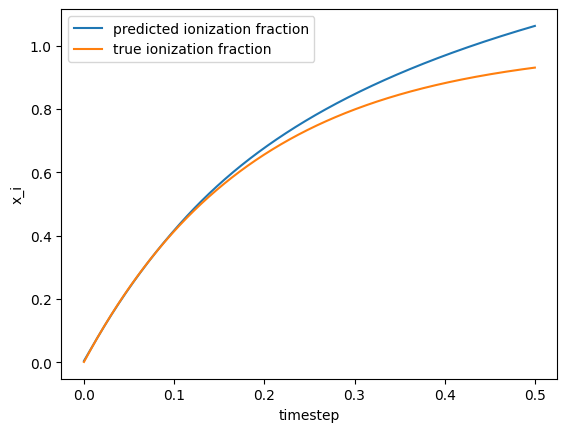

In [20]:
plt.plot(x, model_1(x).detach().numpy(), label="predicted ionization fraction")
plt.plot(x, y, label="true ionization fraction")
plt.xlabel("timestep")
plt.ylabel("x_i")
plt.legend()

In [21]:
run = Run('modified_time/second_phase')

run.data_handler = DataHandler(x, y, 2000, 20)
run.model = model_1

run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = lambda x, y: physics_loss_fn(x, y, loss_coef=1e4)

run.train(5000)

torch.Size([100, 1]) torch.Size([9900, 1])


  0%|          | 1/5000 [00:00<14:00,  5.95it/s]

100%|██████████| 5000/5000 [08:33<00:00,  9.73it/s]


In [22]:
run.score()

tensor(0.9772)

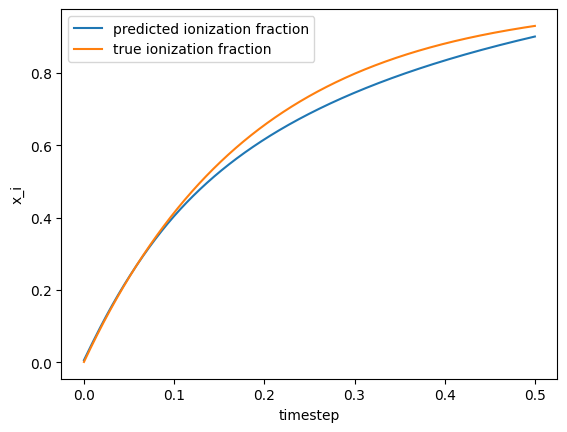

In [23]:
plt.plot(x, model_1(x).detach().numpy(), label="predicted ionization fraction")
plt.plot(x, y, label="true ionization fraction")
plt.xlabel("timestep")
plt.ylabel("x_i")
plt.legend()

# Activation in the end

In [25]:
model = FCN_with_last_activation([1, 8, 8, 8, 8, 8, 1], last_activation=torch.nn.Tanh)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = Run('modified_time/last_tanh')

run.data_handler = DataHandler(x, y, 2000, 20)
run.model = model

run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = None

run.train(5000)

torch.Size([100, 1]) torch.Size([9900, 1])


100%|██████████| 5000/5000 [02:25<00:00, 34.42it/s]


In [26]:
run.score()

tensor(0.9305)

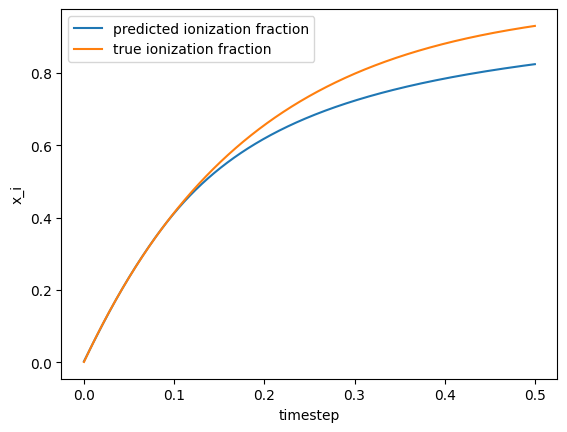

In [27]:
plt.plot(x, model(x).detach().numpy(), label="predicted ionization fraction")
plt.plot(x, y, label="true ionization fraction")
plt.xlabel("timestep")
plt.ylabel("x_i")
plt.legend()

# Activation and physics loss

In [29]:
model = FCN_with_last_activation([1, 8, 8, 8, 8, 8, 1], last_activation=torch.nn.Tanh)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = Run('modified_time/last_tanh_physics_loss')

run.data_handler = DataHandler(x, y, 2000, 20)
run.model = model

run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = lambda x, y: physics_loss_fn(x, y, loss_coef=1000)

run.train(5000)

torch.Size([100, 1]) torch.Size([9900, 1])


100%|██████████| 5000/5000 [07:46<00:00, 10.71it/s]


In [30]:
run.score()

tensor(0.8572)

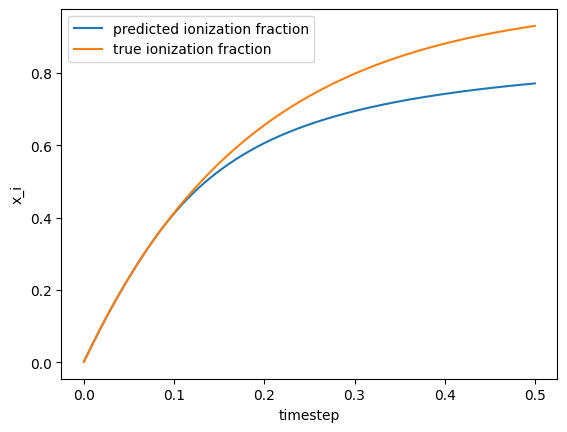

In [31]:
plt.plot(x, model(x).detach().numpy(), label="predicted ionization fraction")
plt.plot(x, y, label="true ionization fraction")
plt.xlabel("timestep")
plt.ylabel("x_i")
plt.legend()